# Lamb-waves in thin plates

In [1]:
import numpy as np
import sympy as sp
import matplotlib as mpl
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import math
import scipy.optimize as opt
import scipy.stats as nst
from scipy.fftpack import fft2
import scipy.ndimage as nim

sp.init_printing()

EXTENSIE = "pdf"

In [2]:
plt.style.use("seaborn-talk")

%matplotlib notebook

## Constants

In [3]:
ct = 3.18e3 #m/s - velocity of transverse waves
cl = 5.79e3 #m/s - velocity of longitudinal waves
d = 0.001 #m - thickness of the plate

## theoretische curves 

In [4]:
def alpha(omega, k):
    a2 = omega**2/cl - k**2
    return np.sqrt(np.abs(a2))

def beta(omega, k):
    b2 = omega**2/ct - k**2
    return np.sqrt(np.abs(b2))

def lhs(omega, k):
    if omega**2 > k**2 * cl:
        return np.tan(d/2*beta(omega, k))/np.tan(d/2*alpha(omega, k))
    elif omega**2 > k**2 * ct:
        return -np.tan(d/2*beta(omega, k))/np.tanh(d/2*alpha(omega, k))
    else:
        return -np.tanh(d/2*beta(omega, k))/np.tanh(d/2*alpha(omega, k))
        
def rhs_s(omega, k):
    return -4*alpha(omega, k)*beta(omega, k)*k**2/(beta(omega, k)**2 - k**2)**2

def rhs_a(omega, k):
    return 1/rhs_s(omega, k)

def S(omega, k):
    return lhs(omega, k) - rhs_s(omega, k)

def A(omega, k):
    return lhs(omega, k) - rhs_a(omega, k)

### golfgetal in functie van hoekfrequentie

symetrische curves

In [14]:
SIDE = 2000

extent = (-3e5, 3e5, -2, 2)
F = np.linspace(extent[0], extent[1], SIDE)
VP = np.linspace(extent[2], extent[3], SIDE)

grid = np.zeros((SIDE, SIDE))

for x in range(SIDE):
    for y in range(SIDE):
        grid[y, x] = S(OMEGA[x], K[y])

In [10]:
im = np.sign(grid)

sx = nim.sobel(im, axis=0, mode='constant')
sy = nim.sobel(im, axis=1, mode='constant')
border = np.hypot(sx, sy)

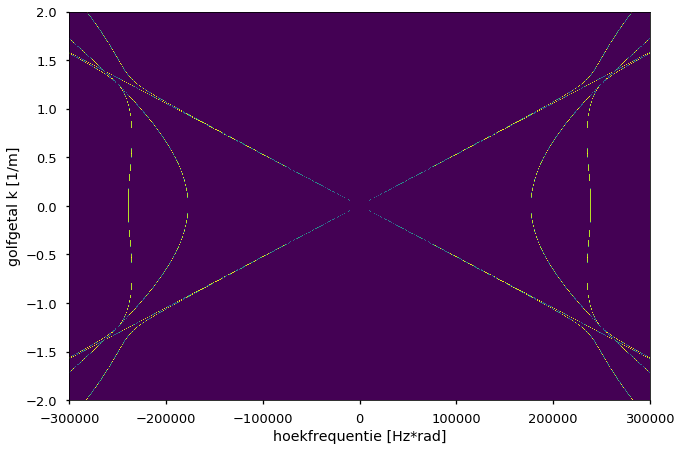

In [16]:
fig, ax = plt.subplots(1,1)

ax.imshow(border, extent=extent, aspect='auto')
ax.set_ylabel("golfgetal k [1/m]")
ax.set_xlabel("hoekfrequentie [Hz*rad]")

plt.show()

fig.savefig("theorie:k-omega-S.png", dpi=600)

assymetrische curves

In [17]:
grid = np.zeros((SIDE, SIDE))

for x in range(SIDE):
    for y in range(SIDE):
        grid[y, x] = A(OMEGA[x], K[y])

In [18]:
im = np.sign(grid)

sx = nim.sobel(im, axis=0, mode='constant')
sy = nim.sobel(im, axis=1, mode='constant')
border = np.hypot(sx, sy)

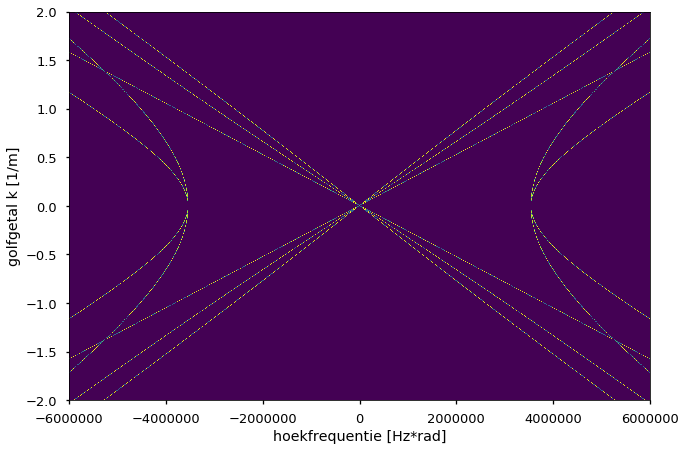

In [19]:
fig, ax = plt.subplots(1,1)

ax.imshow(border, extent=(-6e6, 6e6, -2, 2), aspect='auto')
ax.set_ylabel("golfgetal k [1/m]")
ax.set_xlabel("hoekfrequentie [Hz*rad]")

plt.show()

fig.savefig("theorie:k-omega-A.png", dpi=600)

### fasesnelheid in functie van frequentie

Curves voor symmetrische modes

In [20]:
SIDE = 2000

extent = (1e3, 5e5, 2, 30)

F = np.linspace(extent[0], extent[1], SIDE)
VP = np.linspace(extent[2], extent[3], SIDE)
grid = np.zeros((SIDE, SIDE))

for x in range(SIDE):
    for y in range(SIDE):
        omega = 2*np.pi*F[x]
        k = F[x]/VP[-(y+1)]
        grid[x, y] = S(omega, k)

In [21]:
im = np.sign(grid)

sx = nim.sobel(im, axis=0, mode='constant')
sy = nim.sobel(im, axis=1, mode='constant')
border = np.hypot(sx, sy)

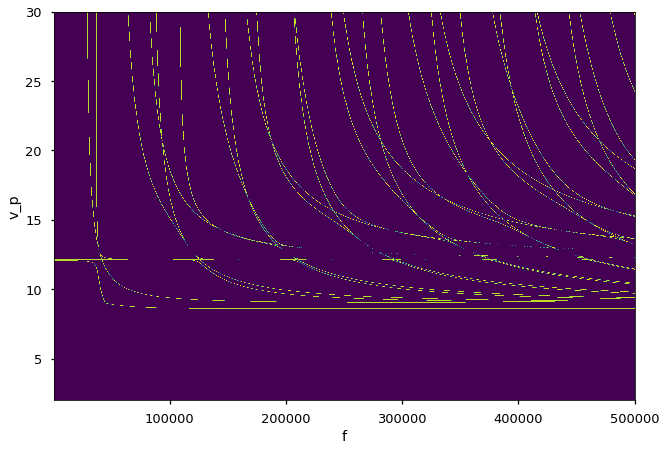

In [22]:
fig, ax = plt.subplots(1,1)

ax.imshow(np.transpose(border), extent=extent, aspect='auto')
ax.set_xlabel("f")
ax.set_ylabel("v_p")

plt.show()

fig.savefig("theorie:f-vp-S.png", dpi=600)

Curves voor asymmetrische modes

In [23]:
grid = np.zeros((SIDE, SIDE))

for x in range(SIDE):
    for y in range(SIDE):
        omega = 2*np.pi*F[x]
        k = F[x]/VP[-(y+1)]
        grid[x, y] = A(omega, k)

In [24]:
im = np.sign(grid)

sx = nim.sobel(im, axis=0, mode='constant')
sy = nim.sobel(im, axis=1, mode='constant')
border = np.hypot(sx, sy)

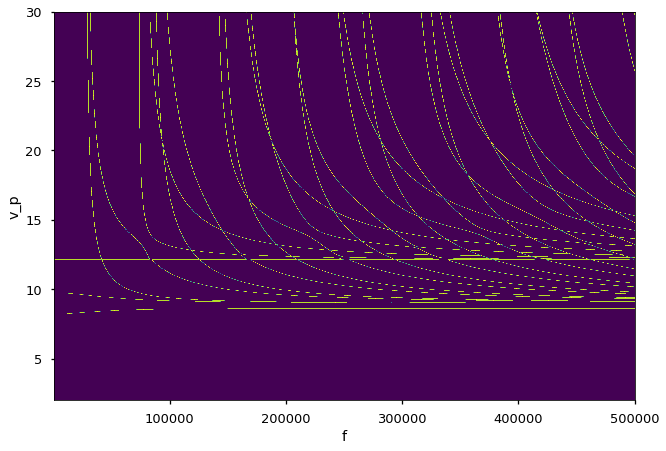

In [25]:
fig, ax = plt.subplots(1,1)

ax.imshow(np.transpose(border), extent=extent, aspect='auto')
ax.set_xlabel("f")
ax.set_ylabel("v_p")

plt.show()

fig.savefig("theorie:f-vp-A.png", dpi=600)

## Inladen data

In [27]:
displacement_array = np.loadtxt("metingen/Scanpump_Ch1_0_X0.txt")

distance = 50

while distance <= 50050:
    ar = np.loadtxt("metingen/Scanpump_Ch1_0_X%d.txt" %distance)
    displacement_array = np.vstack([displacement_array, ar])
    distance += 50
    if distance % 5000 == 0:
        print(distance)

5000
10000
15000
20000
25000
30000
35000
40000
45000
50000


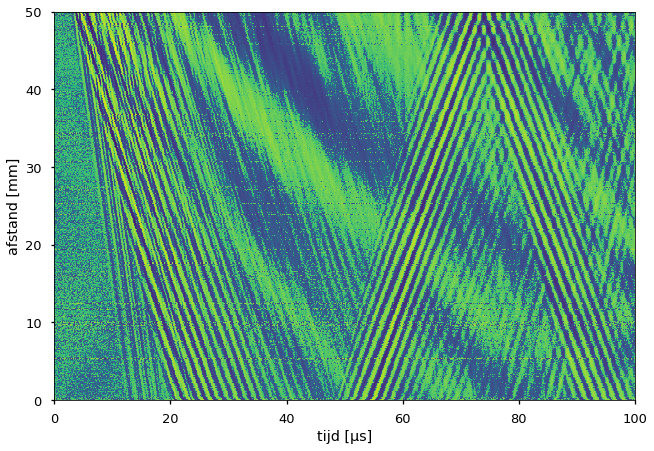

In [33]:
fig, ax = plt.subplots(1,1)

d = np.sign(displacement_array) * np.abs(displacement_array)**0.25
ax.imshow(d[:,:], aspect='auto', cmap='viridis', interpolation='none', extent=(0, 100, 0, 50))

ax.set_xlabel("tijd [µs]")
ax.set_ylabel("afstand [mm]")

plt.show()

#fig.savefig("ampiltude.png", dpi=600)

In [ ]:
f_k = fft2(d[:,:])

In [ ]:
f_k.shape

<IPython.core.display.Javascript object>


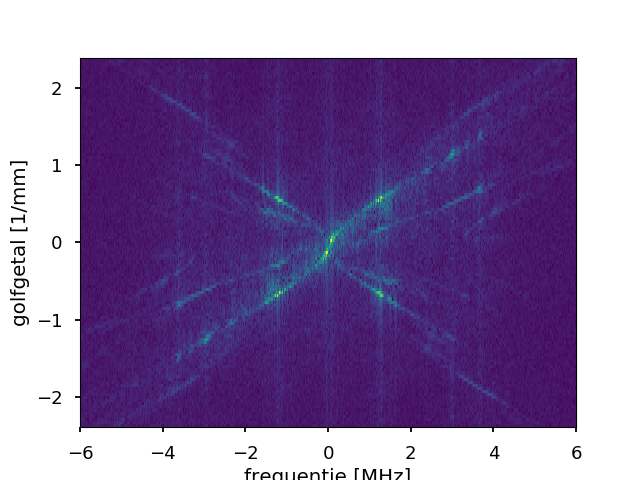

In [22]:
fig, ax = plt.subplots(1,1)

shape = f_k.shape
f_k = np.roll(f_k, shape[0]//2, 0)
f_k = np.roll(f_k, shape[1]//2, 1)
ax.imshow(np.abs(f_k[440:560, 12200:12800])**0.45, aspect='auto', cmap='viridis', interpolation='none',
         extent = (-250/12501*300, 250/12501*300, -20/501*60, 20/501*60))
ax.set_xlabel("frequentie [MHz]")
ax.set_ylabel("golfgetal [1/mm]")

#ax.set_xlabel("tijd [µs]")
#ax.set_ylabel("afstand [mm]")

plt.show()

#fig.savefig("fourrier transform.png", dpi=1200)

In [68]:
?ax.imshow

## Animatie trilling plaat

<IPython.core.display.Javascript object>


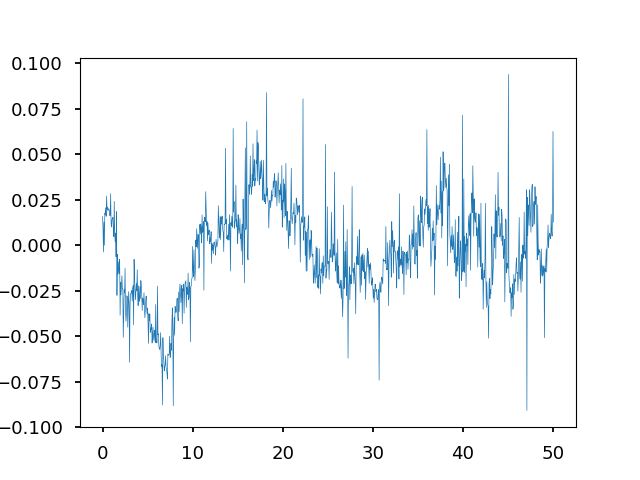

In [51]:
# test plotten spacial data
fig, ax = plt.subplots(1,1)

X = np.arange(0.0, 50.100, 0.05)

ax.plot(X, displacement_array[:,10000], linewidth=0.5)

plt.show()

In [52]:
np.max(displacement_array)

In [53]:
np.min(displacement_array)

In [54]:
np.size(displacement_array[:,1])

<IPython.core.display.Javascript object>


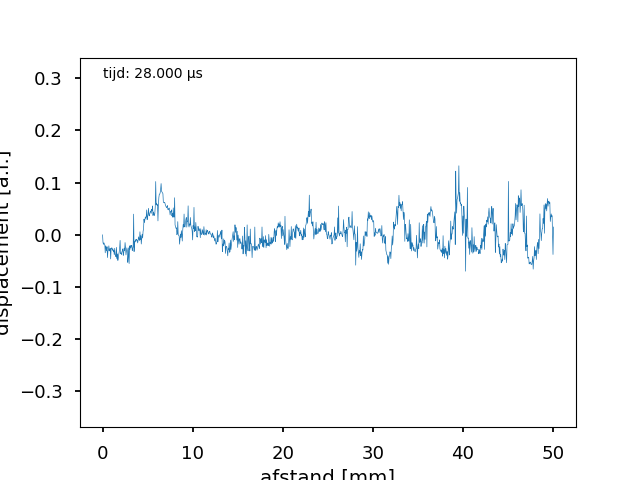

In [55]:
STEP = 10
FRAMES = 1000
fig, ax = plt.subplots(1,1)

X = np.arange(0.0, 50.100, 0.05)

curve, = ax.plot(X, displacement_array[:,0], linewidth=0.5)
text = ax.text(0.0, 0.3, "tijd: %.3f µs" %0.0)

ax.set_ylim(-0.37, 0.34)
ax.set_xlabel("afstand [mm]")
ax.set_ylabel("displacement [a.i.]")

def animate(i):
    curve.set_data(X, displacement_array[:,i*STEP])
    text.set_text("tijd: %.3f µs" %(i*STEP/250))
    
anim = animation.FuncAnimation(fig, animate, frames=FRAMES, interval=50)
plt.show()